CMPE 258 Final Project Python 2.7 Version
1. Author: Tu Lan 011495497 tu.lan@sjsu.edu
2. Date: 05/06/2018
3. Tips: Before running the code, please change the Directories to yours, especially the directory of datasets

In [3]:
# basic libraries
import os               # a system library, not related to algorithm          
import matplotlib.pyplot as plt
import numpy as np
import tifffile as tiff

# state control
state = 1
np.random.seed(state)

# To plot pretty figures
import seaborn as sns  # just a plot library. Not related to algorithms
%matplotlib inline
plt.style.use('seaborn')
sns.set(style="ticks", color_codes=True)

# Directories
PROJECT_ROOT_PATH = '/media/tulan/Linux/Pycharm/EM Cell Tracking/'
DATA_PATH = '/media/tulan/Linux/Pycharm/EM Cell Tracking/data/'
MODEL_PATH = '/media/tulan/Linux/Pycharm/EM Cell Tracking/model/'
LOG_PATH = '/media/tulan/Linux/Pycharm/EM Cell Tracking/log/'
WEIGHT_PATH = '/media/tulan/Linux/Pycharm/EM Cell Tracking/weight/'
RESULT_PATH = '/media/tulan/Linux/Pycharm/EM Cell Tracking/result/'

In [4]:
img = tiff.imread(DATA_PATH + 'train-volume.tif')
msk = tiff.imread(DATA_PATH + 'train-labels.tif')

img.shape, msk.shape

((30, 512, 512), (30, 512, 512))

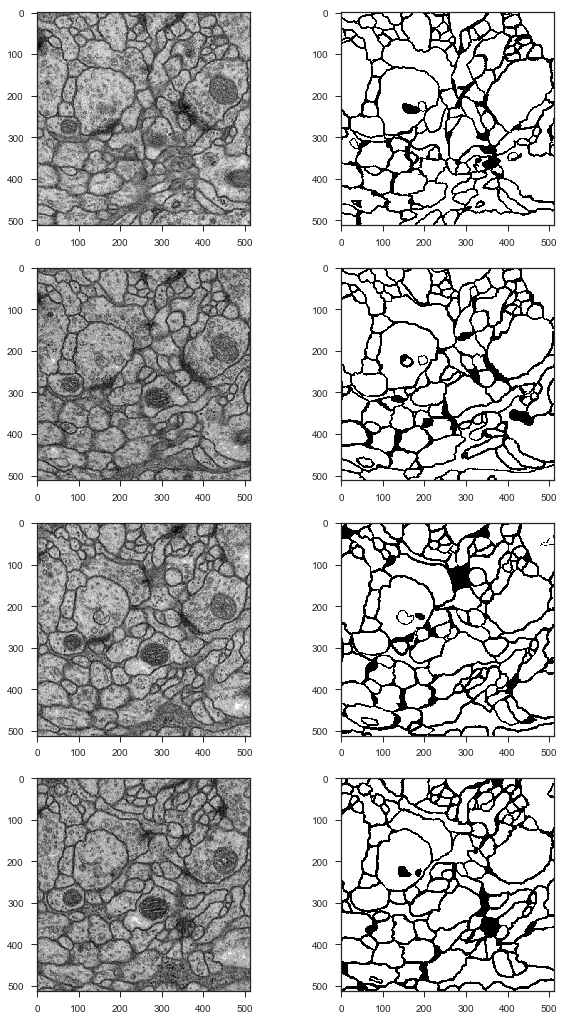

In [5]:
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(10, 18))
for row in range(4):
    ax[row, 0].imshow(img[row], cmap='gray')
    ax[row, 1].imshow(msk[row], cmap='gray')
    
plt.show()

In [12]:
img[0]

array([[126, 107, 122, ..., 161, 164, 177],
       [138, 118, 123, ..., 153, 149, 153],
       [141, 135, 145, ..., 144, 145, 137],
       ...,
       [155, 149, 168, ..., 139, 115, 120],
       [163, 154, 166, ..., 158, 141, 148],
       [151, 141, 160, ..., 183, 164, 171]], dtype=uint8)

In [13]:
msk[0]

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

In [6]:
msk[msk == 0] = 1
msk[msk == 255] = 0

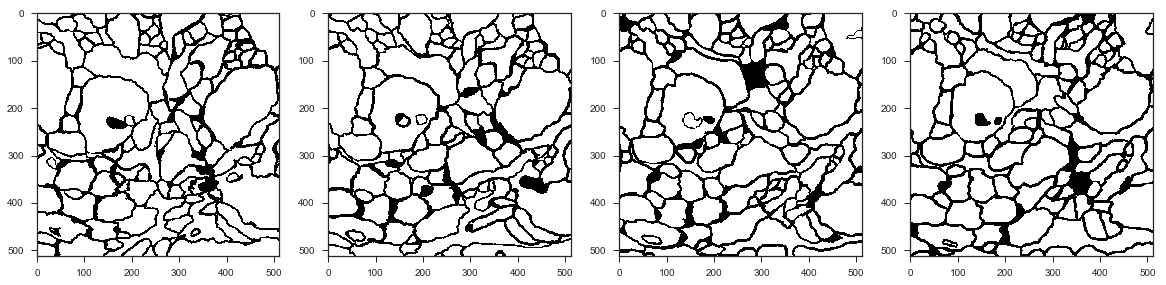

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
for col in range(4):
    ax[col].imshow(msk[col], cmap='binary')
plt.show()

In [8]:
test_img = tiff.imread(DATA_PATH + 'test-volume.tif')
test_img.shape

(30, 512, 512)

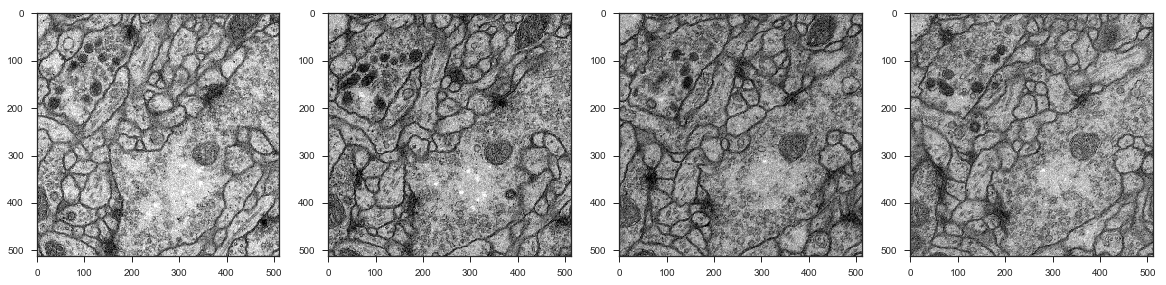

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
for col in range(4):
    ax[col].imshow(test_img[col], cmap='gray')
plt.show()

In [10]:
img = img.reshape((-1, 512, 512, 1))
msk = msk.reshape((-1, 512, 512, 1))
test_img = test_img.reshape((-1, 512, 512, 1))
img.shape, msk.shape, test_img.shape

((30, 512, 512, 1), (30, 512, 512, 1), (30, 512, 512, 1))

In [11]:
np.save(DATA_PATH + 'X_train_ori.npy', img)
np.save(DATA_PATH + 'y_train_ori.npy', msk)
np.save(DATA_PATH + 'X_test.npy', test_img)

In [12]:
X_train = np.load(DATA_PATH + 'X_train_ori.npy')
y_train = np.load(DATA_PATH + 'y_train_ori.npy')
X_test = np.load(DATA_PATH + 'X_test.npy')
X_train.shape, y_train.shape, X_test.shape

((30, 512, 512, 1), (30, 512, 512, 1), (30, 512, 512, 1))

In [21]:
def split_train_val(X, y, ratio_train, state):
    # shuffle the sequence
    np.random.seed(state)
    num = len(y)
    shuffle_index = np.random.permutation(num)
    train_index = shuffle_index[:int(num * ratio_train)]
    val_index = shuffle_index[int(num * ratio_train):]
    X_train, y_train = X[train_index], y[train_index]
    X_val, y_val = X[val_index], y[val_index]
    return X_train, X_val, y_train, y_val


X_train, X_val, y_train, y_val = split_train_val(X_train, y_train, 0.9, state)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((27, 512, 512, 1), (3, 512, 512, 1), (27, 512, 512, 1), (3, 512, 512, 1))

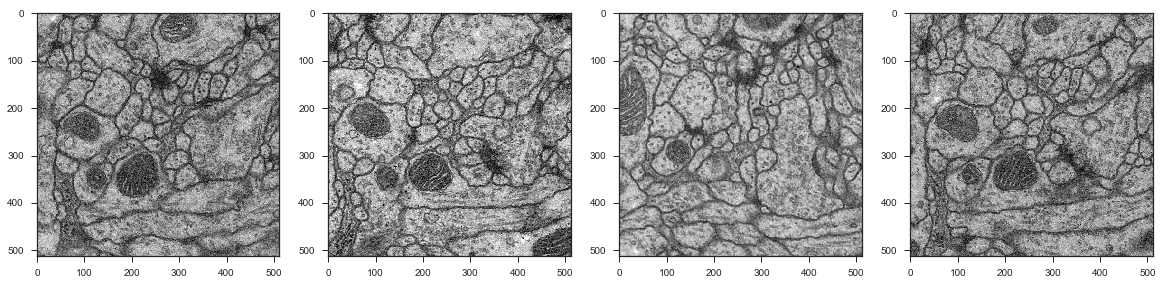

In [22]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20, 6))
for col in range(4):
    ax[col].imshow(X_train[col].reshape(512, 512), cmap='gray')
plt.show()

In [29]:
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from ResNet_UNet_Side_Fuse import u_res_side_fuse
from U_Net import u_net_ori
from Loss_Functions import dice_coef, dice_coef_loss, pixel_error, cross_entropy_balanced, \
    jaccard_coef

In [35]:
model_unet = u_net_ori(input_shape=(512, 512, 1))
model_unet.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 512, 512, 1)  0                                            
__________________________________________________________________________________________________
lambda_6 (Lambda)               (None, 512, 512, 1)  0           input_6[0][0]                    
__________________________________________________________________________________________________
conv_1a (Conv2D)                (None, 512, 512, 8)  80          lambda_6[0][0]                   
__________________________________________________________________________________________________
conv_1b (Conv2D)                (None, 512, 512, 8)  584         conv_1a[0][0]                    
__________________________________________________________________________________________________
pool_1 (Ma

In [36]:
lr_decay = ReduceLROnPlateau(monitor='val_pixel_error', factor=0.8, patience=5, 
                             verbose=1, min_lr=1e-5)
checkpointer = ModelCheckpoint(MODEL_PATH + 'checkpoint.h5', verbose=1, save_best_only=True)
tensorbord = TensorBoard(log_dir=LOG_PATH + 'baseline/', write_graph=True)
callback_list = [lr_decay, checkpointer, tensorbord]

# optimizer = SGD(lr=1e-3, momentum=0.9, nesterov=False)
optimizer = Adam(lr=1e-3, beta_1=0.9, beta_2=0.999)

model_unet.compile(optimizer=optimizer, loss=cross_entropy_balanced, metrics=[dice_coef, 
                                                    jaccard_coef, pixel_error])

results = model_unet.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=1, 
                         epochs=50, callbacks=callback_list, verbose=2)

Train on 27 samples, validate on 3 samples


Epoch 1/50


 - 2s - loss: 0.2171 - dice_coef: 0.3259 - jaccard_coef: 0.1914 - pixel_error: 0.2841 - val_loss: 0.1966 - val_dice_coef: 0.4359 - val_jaccard_coef: 0.2735 - val_pixel_error: 0.1703



Epoch 00001: val_loss improved from inf to 0.19656, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 2/50


 - 1s - loss: 0.1532 - dice_coef: 0.4935 - jaccard_coef: 0.3217 - pixel_error: 0.2009 - val_loss: 0.1490 - val_dice_coef: 0.5846 - val_jaccard_coef: 0.4065 - val_pixel_error: 0.1755



Epoch 00002: val_loss improved from 0.19656 to 0.14898, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5
Epoch 3/50


 - 1s - loss: 0.1247 - dice_coef: 0.5892 - jaccard_coef: 0.4109 - pixel_error: 0.1705 - val_loss: 0.1414 - val_dice_coef: 0.6125 - val_jaccard_coef: 0.4353 - val_pixel_error: 0.1571



Epoch 00003: val_loss improved from 0.14898 to 0.14143, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5
Epoch 4/50


 - 1s - loss: 0.1199 - dice_coef: 0.6020 - jaccard_coef: 0.4237 - pixel_error: 0.1631 - val_loss: 0.1339 - val_dice_coef: 0.6369 - val_jaccard_coef: 0.4615 - val_pixel_error: 0.1599



Epoch 00004: val_loss improved from 0.14143 to 0.13394, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5
Epoch 5/50


 - 1s - loss: 0.1150 - dice_coef: 0.6196 - jaccard_coef: 0.4417 - pixel_error: 0.1558 - val_loss: 0.1321 - val_dice_coef: 0.6320 - val_jaccard_coef: 0.4557 - val_pixel_error: 0.1870



Epoch 00005: val_loss improved from 0.13394 to 0.13215, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5
Epoch 6/50


 - 1s - loss: 0.1136 - dice_coef: 0.6176 - jaccard_coef: 0.4390 - pixel_error: 0.1571 - val_loss: 0.1247 - val_dice_coef: 0.6647 - val_jaccard_coef: 0.4919 - val_pixel_error: 0.1422



Epoch 00006: val_loss improved from 0.13215 to 0.12470, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5
Epoch 7/50


 - 1s - loss: 0.1046 - dice_coef: 0.6498 - jaccard_coef: 0.4741 - pixel_error: 0.1421 - val_loss: 0.1231 - val_dice_coef: 0.6527 - val_jaccard_coef: 0.4776 - val_pixel_error: 0.1548



Epoch 00007: val_loss improved from 0.12470 to 0.12312, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5
Epoch 8/50


 - 1s - loss: 0.1005 - dice_coef: 0.6599 - jaccard_coef: 0.4849 - pixel_error: 0.1339 - val_loss: 0.1215 - val_dice_coef: 0.6661 - val_jaccard_coef: 0.4930 - val_pixel_error: 0.1647



Epoch 00008: val_loss improved from 0.12312 to 0.12151, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5
Epoch 9/50


 - 1s - loss: 0.0965 - dice_coef: 0.6714 - jaccard_coef: 0.4983 - pixel_error: 0.1292 - val_loss: 0.1156 - val_dice_coef: 0.6924 - val_jaccard_coef: 0.5238 - val_pixel_error: 0.1339



Epoch 00009: val_loss improved from 0.12151 to 0.11563, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5
Epoch 10/50


 - 1s - loss: 0.0897 - dice_coef: 0.6971 - jaccard_coef: 0.5277 - pixel_error: 0.1177 - val_loss: 0.1164 - val_dice_coef: 0.6914 - val_jaccard_coef: 0.5223 - val_pixel_error: 0.1414



Epoch 00010: val_loss did not improve
Epoch 11/50


 - 1s - loss: 0.0894 - dice_coef: 0.6949 - jaccard_coef: 0.5252 - pixel_error: 0.1206 - val_loss: 0.1173 - val_dice_coef: 0.6900 - val_jaccard_coef: 0.5199 - val_pixel_error: 0.1535



Epoch 00011: val_loss did not improve
Epoch 12/50


 - 1s - loss: 0.0809 - dice_coef: 0.7229 - jaccard_coef: 0.5586 - pixel_error: 0.1076 - val_loss: 0.1155 - val_dice_coef: 0.7137 - val_jaccard_coef: 0.5502 - val_pixel_error: 0.1375



Epoch 00012: val_loss improved from 0.11563 to 0.11545, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5
Epoch 13/50


 - 1s - loss: 0.0786 - dice_coef: 0.7289 - jaccard_coef: 0.5670 - pixel_error: 0.1053 - val_loss: 0.1248 - val_dice_coef: 0.7094 - val_jaccard_coef: 0.5457 - val_pixel_error: 0.1141



Epoch 00013: val_loss did not improve
Epoch 14/50


 - 1s - loss: 0.0736 - dice_coef: 0.7457 - jaccard_coef: 0.5885 - pixel_error: 0.0986 - val_loss: 0.1062 - val_dice_coef: 0.7302 - val_jaccard_coef: 0.5704 - val_pixel_error: 0.1191



Epoch 00014: val_loss improved from 0.11545 to 0.10617, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5
Epoch 15/50


 - 1s - loss: 0.0716 - dice_coef: 0.7568 - jaccard_coef: 0.6030 - pixel_error: 0.0959 - val_loss: 0.1135 - val_dice_coef: 0.7058 - val_jaccard_coef: 0.5408 - val_pixel_error: 0.1318



Epoch 00015: val_loss did not improve
Epoch 16/50


 - 1s - loss: 0.0726 - dice_coef: 0.7431 - jaccard_coef: 0.5854 - pixel_error: 0.0994 - val_loss: 0.1141 - val_dice_coef: 0.7300 - val_jaccard_coef: 0.5709 - val_pixel_error: 0.1154



Epoch 00016: val_loss did not improve
Epoch 17/50


 - 1s - loss: 0.0658 - dice_coef: 0.7700 - jaccard_coef: 0.6208 - pixel_error: 0.0901 - val_loss: 0.1123 - val_dice_coef: 0.7299 - val_jaccard_coef: 0.5730 - val_pixel_error: 0.1184



Epoch 00017: val_loss did not improve
Epoch 18/50


 - 1s - loss: 0.0652 - dice_coef: 0.7700 - jaccard_coef: 0.6210 - pixel_error: 0.0896 - val_loss: 0.1372 - val_dice_coef: 0.7426 - val_jaccard_coef: 0.5890 - val_pixel_error: 0.1108



Epoch 00018: val_loss did not improve
Epoch 19/50


 - 1s - loss: 0.0608 - dice_coef: 0.7829 - jaccard_coef: 0.6387 - pixel_error: 0.0848 - val_loss: 0.1241 - val_dice_coef: 0.7470 - val_jaccard_coef: 0.5949 - val_pixel_error: 0.1109



Epoch 00019: val_loss did not improve
Epoch 20/50


 - 1s - loss: 0.0620 - dice_coef: 0.7817 - jaccard_coef: 0.6370 - pixel_error: 0.0858 - val_loss: 0.1314 - val_dice_coef: 0.7490 - val_jaccard_coef: 0.5975 - val_pixel_error: 0.1162



Epoch 00020: val_loss did not improve
Epoch 21/50


 - 1s - loss: 0.0605 - dice_coef: 0.7847 - jaccard_coef: 0.6412 - pixel_error: 0.0832 - val_loss: 0.1290 - val_dice_coef: 0.7547 - val_jaccard_coef: 0.6042 - val_pixel_error: 0.1132



Epoch 00021: val_loss did not improve
Epoch 22/50


 - 1s - loss: 0.0591 - dice_coef: 0.7910 - jaccard_coef: 0.6501 - pixel_error: 0.0819 - val_loss: 0.1258 - val_dice_coef: 0.7534 - val_jaccard_coef: 0.6012 - val_pixel_error: 0.1154



Epoch 00022: val_loss did not improve
Epoch 23/50


 - 1s - loss: 0.0569 - dice_coef: 0.7976 - jaccard_coef: 0.6591 - pixel_error: 0.0789 - val_loss: 0.1217 - val_dice_coef: 0.7534 - val_jaccard_coef: 0.6022 - val_pixel_error: 0.1157



Epoch 00023: val_loss did not improve
Epoch 24/50


 - 1s - loss: 0.0558 - dice_coef: 0.8004 - jaccard_coef: 0.6631 - pixel_error: 0.0782 - val_loss: 0.1353 - val_dice_coef: 0.7554 - val_jaccard_coef: 0.6046 - val_pixel_error: 0.1094



Epoch 00024: val_loss did not improve
Epoch 25/50


 - 1s - loss: 0.0541 - dice_coef: 0.8067 - jaccard_coef: 0.6719 - pixel_error: 0.0750 - val_loss: 0.1360 - val_dice_coef: 0.7583 - val_jaccard_coef: 0.6083 - val_pixel_error: 0.1115



Epoch 00025: val_loss did not improve
Epoch 26/50


 - 1s - loss: 0.0547 - dice_coef: 0.8038 - jaccard_coef: 0.6678 - pixel_error: 0.0764 - val_loss: 0.1412 - val_dice_coef: 0.7579 - val_jaccard_coef: 0.6086 - val_pixel_error: 0.1064



Epoch 00026: val_loss did not improve
Epoch 27/50


 - 1s - loss: 0.0517 - dice_coef: 0.8126 - jaccard_coef: 0.6797 - pixel_error: 0.0731 - val_loss: 0.1379 - val_dice_coef: 0.7577 - val_jaccard_coef: 0.6086 - val_pixel_error: 0.1100



Epoch 00027: val_loss did not improve
Epoch 28/50


 - 1s - loss: 0.0501 - dice_coef: 0.8196 - jaccard_coef: 0.6902 - pixel_error: 0.0703 - val_loss: 0.1625 - val_dice_coef: 0.7575 - val_jaccard_coef: 0.6080 - val_pixel_error: 0.1064



Epoch 00028: val_loss did not improve
Epoch 29/50


 - 1s - loss: 0.0483 - dice_coef: 0.8244 - jaccard_coef: 0.6970 - pixel_error: 0.0681 - val_loss: 0.1691 - val_dice_coef: 0.7613 - val_jaccard_coef: 0.6134 - val_pixel_error: 0.1073



Epoch 00029: val_loss did not improve
Epoch 30/50


 - 1s - loss: 0.0477 - dice_coef: 0.8263 - jaccard_coef: 0.6997 - pixel_error: 0.0669 - val_loss: 0.1596 - val_dice_coef: 0.7583 - val_jaccard_coef: 0.6101 - val_pixel_error: 0.1102



Epoch 00030: val_loss did not improve
Epoch 31/50


 - 1s - loss: 0.0473 - dice_coef: 0.8285 - jaccard_coef: 0.7032 - pixel_error: 0.0668 - val_loss: 0.2223 - val_dice_coef: 0.7419 - val_jaccard_coef: 0.5897 - val_pixel_error: 0.1074



Epoch 00031: val_loss did not improve
Epoch 32/50


 - 1s - loss: 0.0477 - dice_coef: 0.8271 - jaccard_coef: 0.7007 - pixel_error: 0.0668 - val_loss: 0.1650 - val_dice_coef: 0.7636 - val_jaccard_coef: 0.6158 - val_pixel_error: 0.1081



Epoch 00032: ReduceLROnPlateau reducing learning rate to 0.000800000037998.

Epoch 00032: val_loss did not improve
Epoch 33/50


 - 1s - loss: 0.0449 - dice_coef: 0.8354 - jaccard_coef: 0.7135 - pixel_error: 0.0635 - val_loss: 0.1685 - val_dice_coef: 0.7639 - val_jaccard_coef: 0.6168 - val_pixel_error: 0.1123



Epoch 00033: val_loss did not improve
Epoch 34/50


 - 1s - loss: 0.0426 - dice_coef: 0.8445 - jaccard_coef: 0.7269 - pixel_error: 0.0598 - val_loss: 0.1797 - val_dice_coef: 0.7623 - val_jaccard_coef: 0.6151 - val_pixel_error: 0.1093



Epoch 00034: val_loss did not improve
Epoch 35/50


 - 1s - loss: 0.0411 - dice_coef: 0.8479 - jaccard_coef: 0.7321 - pixel_error: 0.0582 - val_loss: 0.1876 - val_dice_coef: 0.7649 - val_jaccard_coef: 0.6188 - val_pixel_error: 0.1097



Epoch 00035: val_loss did not improve
Epoch 36/50


 - 1s - loss: 0.0398 - dice_coef: 0.8533 - jaccard_coef: 0.7402 - pixel_error: 0.0561 - val_loss: 0.1876 - val_dice_coef: 0.7682 - val_jaccard_coef: 0.6226 - val_pixel_error: 0.1087



Epoch 00036: val_loss did not improve
Epoch 37/50


 - 1s - loss: 0.0393 - dice_coef: 0.8557 - jaccard_coef: 0.7440 - pixel_error: 0.0551 - val_loss: 0.2181 - val_dice_coef: 0.7626 - val_jaccard_coef: 0.6155 - val_pixel_error: 0.1114



Epoch 00037: ReduceLROnPlateau reducing learning rate to 0.000640000030398.

Epoch 00037: val_loss did not improve
Epoch 38/50


 - 1s - loss: 0.0375 - dice_coef: 0.8602 - jaccard_coef: 0.7507 - pixel_error: 0.0533 - val_loss: 0.2288 - val_dice_coef: 0.7626 - val_jaccard_coef: 0.6164 - val_pixel_error: 0.1088



Epoch 00038: val_loss did not improve
Epoch 39/50


 - 1s - loss: 0.0360 - dice_coef: 0.8666 - jaccard_coef: 0.7608 - pixel_error: 0.0505 - val_loss: 0.2296 - val_dice_coef: 0.7617 - val_jaccard_coef: 0.6152 - val_pixel_error: 0.1080



Epoch 00039: val_loss did not improve
Epoch 40/50


 - 1s - loss: 0.0349 - dice_coef: 0.8705 - jaccard_coef: 0.7668 - pixel_error: 0.0487 - val_loss: 0.2289 - val_dice_coef: 0.7677 - val_jaccard_coef: 0.6224 - val_pixel_error: 0.1097



Epoch 00040: val_loss did not improve
Epoch 41/50


 - 1s - loss: 0.0339 - dice_coef: 0.8737 - jaccard_coef: 0.7719 - pixel_error: 0.0476 - val_loss: 0.2572 - val_dice_coef: 0.7612 - val_jaccard_coef: 0.6147 - val_pixel_error: 0.1099



Epoch 00041: val_loss did not improve
Epoch 42/50


 - 1s - loss: 0.0331 - dice_coef: 0.8763 - jaccard_coef: 0.7762 - pixel_error: 0.0465 - val_loss: 0.2533 - val_dice_coef: 0.7637 - val_jaccard_coef: 0.6181 - val_pixel_error: 0.1090



Epoch 00042: ReduceLROnPlateau reducing learning rate to 0.000512000033632.

Epoch 00042: val_loss did not improve
Epoch 43/50


 - 1s - loss: 0.0325 - dice_coef: 0.8789 - jaccard_coef: 0.7805 - pixel_error: 0.0454 - val_loss: 0.2713 - val_dice_coef: 0.7609 - val_jaccard_coef: 0.6151 - val_pixel_error: 0.1084



Epoch 00043: val_loss did not improve
Epoch 44/50


 - 1s - loss: 0.0319 - dice_coef: 0.8810 - jaccard_coef: 0.7839 - pixel_error: 0.0446 - val_loss: 0.2695 - val_dice_coef: 0.7638 - val_jaccard_coef: 0.6185 - val_pixel_error: 0.1106



Epoch 00044: val_loss did not improve
Epoch 45/50


 - 1s - loss: 0.0311 - dice_coef: 0.8833 - jaccard_coef: 0.7875 - pixel_error: 0.0435 - val_loss: 0.2866 - val_dice_coef: 0.7634 - val_jaccard_coef: 0.6181 - val_pixel_error: 0.1105



Epoch 00045: val_loss did not improve
Epoch 46/50


 - 1s - loss: 0.0302 - dice_coef: 0.8863 - jaccard_coef: 0.7924 - pixel_error: 0.0423 - val_loss: 0.2798 - val_dice_coef: 0.7623 - val_jaccard_coef: 0.6162 - val_pixel_error: 0.1097



Epoch 00046: val_loss did not improve
Epoch 47/50


 - 1s - loss: 0.0293 - dice_coef: 0.8904 - jaccard_coef: 0.7991 - pixel_error: 0.0405 - val_loss: 0.2790 - val_dice_coef: 0.7647 - val_jaccard_coef: 0.6193 - val_pixel_error: 0.1106



Epoch 00047: ReduceLROnPlateau reducing learning rate to 0.000409600045532.

Epoch 00047: val_loss did not improve
Epoch 48/50


 - 1s - loss: 0.0282 - dice_coef: 0.8935 - jaccard_coef: 0.8042 - pixel_error: 0.0393 - val_loss: 0.2833 - val_dice_coef: 0.7656 - val_jaccard_coef: 0.6211 - val_pixel_error: 0.1099



Epoch 00048: val_loss did not improve
Epoch 49/50


 - 1s - loss: 0.0277 - dice_coef: 0.8959 - jaccard_coef: 0.8082 - pixel_error: 0.0382 - val_loss: 0.3023 - val_dice_coef: 0.7639 - val_jaccard_coef: 0.6190 - val_pixel_error: 0.1110



Epoch 00049: val_loss did not improve
Epoch 50/50


 - 1s - loss: 0.0269 - dice_coef: 0.8989 - jaccard_coef: 0.8132 - pixel_error: 0.0371 - val_loss: 0.3059 - val_dice_coef: 0.7651 - val_jaccard_coef: 0.6204 - val_pixel_error: 0.1117



Epoch 00050: val_loss did not improve


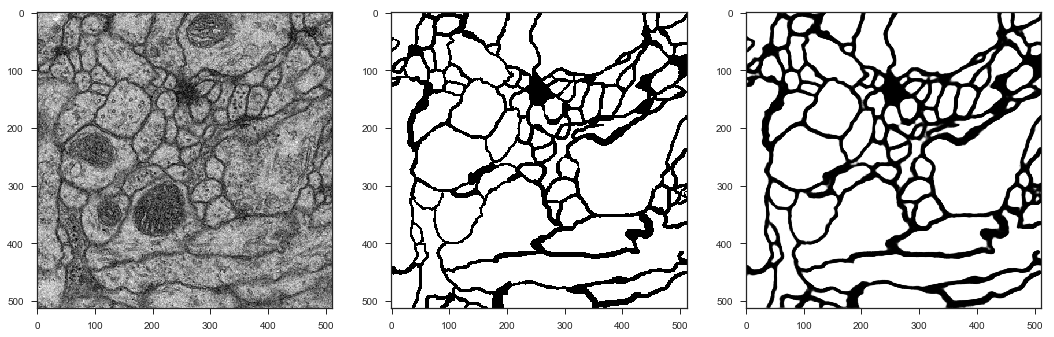

In [39]:
y_pred = model_unet.predict(X_train[0].reshape((-1, 512, 512, 1)))
y_pred = y_pred.reshape((512, 512))
plt.figure(figsize=(18,6))
plt.subplot(1,3,1)
plt.imshow(X_train[0].reshape((512, 512)), cmap='gray')
plt.subplot(1,3,2)
plt.imshow(y_train[0].reshape((512, 512)), cmap='binary')
plt.subplot(1,3,3)
plt.imshow(y_pred, cmap='binary')

plt.show()

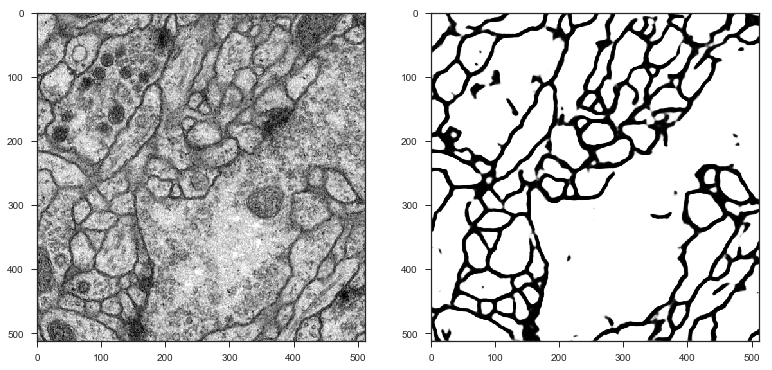

In [40]:
y_pred = model_unet.predict(X_test[0].reshape((-1, 512, 512, 1)))
y_pred = y_pred.reshape((512, 512))
plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.imshow(X_test[0].reshape((512, 512)), cmap='gray')
plt.subplot(1,3,2)
plt.imshow(y_pred, cmap='binary')
plt.show()


In [41]:
model_unet.save_weights(WEIGHT_PATH + 'UNET_base.h5')
model_unet.save(MODEL_PATH + 'UNET_base.h5')
model_json = model_unet.to_json()
with open(MODEL_PATH + 'UNET_base.json', "w") as json_file:
    json_file.write(model_json)